### This notebook uses the original DCTR model (i.e. model expects “empty particles” to have 0 in every entry). As opposerd to the, modified DCTR that was trained to allow non-zero inputs for theta on empty particles, the fit appears less noisy and more stable

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [2]:
# standard library imports
from __future__ import absolute_import, division, print_function

import tensorflow as tf
import keras as keras
import keras.backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, LambdaCallback
from keras.layers import Lambda
from keras.models import Model
# standard numerical library imports
import numpy as np
import scipy as sp

# energyflow imports
import energyflow as ef
from energyflow.archs import PFN
from energyflow.utils import data_split, remap_pids, to_categorical

import matplotlib.pyplot as plt

import inspect

Using TensorFlow backend.


In [3]:
print(keras.__version__) #2.2.4
print(tf.__version__) #1.15.0

2.2.4
1.15.0


# Load Data

## Utilities

In [4]:
# normalize pT and center (y, phi)
def normalize(x):
    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

In [5]:
def preprocess_data(X):
    for x in X:
        normalize(x)
    
    # Remap PIDs to unique values in range [0,1]
    remap_pids(X, pid_i=3)
    return X

## Process data

In [6]:
# Path to downloaded data from Zenodo
data_dir = './data/'

In [7]:
default_dataset = np.load(data_dir + 'test1D_default.npz')
unknown_dataset = np.load(data_dir + 'test1D_aLund.npz')

In [8]:
X_default = preprocess_data(default_dataset['jet'][:,:,:4])
X_unknown = preprocess_data(unknown_dataset['jet'][:,:,:4])

Y_default = np.zeros_like(X_unknown[:,0,0])
Y_unknown = np.ones_like(X_unknown[:,0,0])

In [9]:
X_fit = np.concatenate((X_default, X_unknown), axis = 0)

Y_fit = np.concatenate((Y_default, Y_unknown), axis = 0)

In [10]:
X_train, X_test, Y_train, Y_test = data_split(X_fit, Y_fit, test=0.2, shuffle=True)

In [11]:
#smaller data sets
X_train_small = X_train[0:int(0.8*10**5)]
Y_train_small = Y_train[0:int(0.8*10**5)]
X_test_small = X_test[0:int(0.2*10**5)]
Y_test_small = Y_test[0:int(0.2*10**5)]

# Load Model

In [12]:
# network architecture parameters
Phi_sizes = (100,100, 128)
F_sizes = (100,100, 100)

dctr = PFN(input_dim=7, 
           Phi_sizes=Phi_sizes, F_sizes=F_sizes,
           summary=False)

# load model from saved file
# model trained in original alphaS notebook
dctr.model.load_weights('./saved_models/DCTR_ee_dijets_1D_aLund.h5') #ORIGINAL DCTR

# Fitting

# Defining reweighting functions

$w(x_{T,i},\theta)=((f(x_{T,i},\theta)/(1-f(x_{T,i},\theta)))$

Takes observable from simulation ${\bf \theta_0}$ and weights it to observable from data (target) ${\bf \theta_1}$.

In [13]:
# Defining reweighting functions

def reweight(d): #from NN (DCTR)
    f = dctr.model(d) # Use dctr.model.predict_on_batch(d) when using outside training
    weights = (f[:,1])/(f[:,0])
    weights = K.expand_dims(weights, axis = 1)
    return weights

In [14]:

model = PFN(input_dim=4, 
            Phi_sizes=Phi_sizes, F_sizes=F_sizes, 
            output_dim = 1, output_act = 'sigmoid',
            summary=False)
myinputs = model.inputs[0]
batch_size = 1000

def my_loss_wrapper(inputs, val=0):
    x  = inputs #x.shape = (?,?,4)
    #Reshaping to correct format
    x = tf.gather(x, np.arange(batch_size))
    x = tf.gather(x, np.arange(51), axis = 1) # Axis corressponds to (max) number of particles in each event

    theta_prime = [0.1365, val, 0.217]
    
    # zip theta_prime to each input particle (but not to the padded rows)
    concat_input_and_params = tf.where(K.abs(x[...,0])>0, #checks if pT != 0, which means we have a particle
                                   K.ones_like(x[...,0]),
                                   K.zeros_like(x[...,0]))
    
    concat_input_and_params = theta_prime*K.stack([concat_input_and_params, 
                                                   concat_input_and_params, 
                                                   concat_input_and_params], 
                                                  axis = -1)
    
    data = K.concatenate([x, concat_input_and_params], -1)
    # print(data.shape) # = (batch_size, 51, 7), correct format to pass to DCTR
    w = reweight(data) # NN reweight
    
    def my_loss(y_true,y_pred):
        # Mean-Squared Loss:
        t_loss = (y_true)*(y_true - y_pred)**2 +(w)*(1-y_true)*(y_true - y_pred)**2
        
        # Categorical Cross-Entropy Loss
        '''
        #Clip the prediction value to prevent NaN's and Inf's
        
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        
        t_loss = -((y_true)*K.log(y_pred) +w*(1-y_true)*K.log(1-y_pred))
        '''
        return K.mean(t_loss)
    return my_loss

In [15]:

thetas = np.linspace(0.50, 0.90, 33) #iterating across possible alphaS values
vlvals = []
lvals = []


for theta in thetas:
    print("trainnig theta = :", theta)
    model.model.compile(optimizer='adam', loss=my_loss_wrapper(myinputs,theta),metrics=['accuracy'])
    history = model.fit(X_train, Y_train, epochs=1, batch_size=batch_size,validation_data=(X_test, Y_test),verbose=1)
    vlvals+=[history.history['val_loss']]
    lvals+=[history.history['loss']]
    print
    pass
print(lvals)

trainnig theta = : 0.5
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 1440000 samples, validate on 360000 samples
Epoch 1/1
1440000/1440000 [==============================] - 146s 102us/step - loss: 0.2504 - acc: 0.5091 - val_loss: 0.2496 - val_acc: 0.5112
trainnig theta = : 0.5125
Train on 1440000 samples, validate on 360000 samples
Epoch 1/1
1440000/1440000 [==============================] - 146s 102us/step - loss: 0.2498 - acc: 0.5101 - val_loss: 0.2497 - val_acc: 0.5104
trainnig theta = : 0.525
Train on 1440000 samples, validate on 360000 samples
Epoch 1/1
1440000/1440000 [==============================] - 145s 101us/step - loss: 0.2499 - acc: 0.5108 - val_loss: 0.2499 - val_acc: 0.5110
trainnig theta = : 0.5375
Train on 1440000 samples, validate on 360000 samples
Epoch 1/1
1440000/1440000 [==============================] - 144s 100us/step - loss: 0.2500 - acc: 0.5111 - val_loss: 0.2501 - val_acc: 0.5123
trainnig theta = : 0

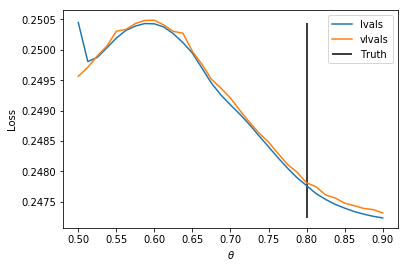

In [16]:
plt.plot(thetas,lvals, label = 'lvals')
plt.plot(thetas,vlvals, label = 'vlvals')
plt.vlines(0.80, ymin = np.min(lvals), ymax = np.max(lvals), label = 'Truth')
plt.xlabel(r'$\theta$')
plt.ylabel('Loss')
plt.legend()
#plt.savefig("aLund vs. Loss.png")

# Tuning with Gradient Descent

In [ ]:
print_weights = LambdaCallback(on_epoch_end=lambda batch, logs: print(". theta fit = ",model_fit.layers[-1].get_weights()[-1]))
theta_fit_init = 0.68
fit_vals = [theta_fit_init]
append_fit_value = LambdaCallback(on_epoch_end=lambda batch, logs: 
                                               fit_vals.append(model_fit.layers[-1].get_weights()[0]))

callbacks = [print_weights, append_fit_value]

In [ ]:
PFN_model = PFN(input_dim=4, 
            Phi_sizes=Phi_sizes, F_sizes=F_sizes, 
            output_dim = 1, output_act = 'sigmoid',
            summary=False)
myinputs_fit = PFN_model.inputs[0]

identity = Lambda(lambda x: x + 0)(PFN_model.output)

model_fit = Model(inputs=myinputs_fit, outputs=identity)
model_fit.layers[np.size(model_fit.layers)-1].add_weight(name="thetaX",shape=list(),
                                                         initializer = keras.initializers.Constant(value = theta_fit_init),
                                                         trainable=True)
model_fit.summary()

train_theta = False

batch_size = 1000
lr = 5e-7 #smaller learning rate yields better precision
epochs = 60 #but requires more epochs to train
optimizer = keras.optimizers.Adam(lr=lr)

def my_loss_wrapper_fit(inputs,mysign = 1):
    x  = inputs #x.shape = (?,?,4)
    # Reshaping to correct format
    x = tf.gather(x, np.arange(batch_size))
    x = tf.gather(x, np.arange(51), axis = 1) # Axis corressponds to (max) number of particles in each event
    
    
    
    #Getting theta0:
    if train_theta == False:
        theta0 = model_fit.layers[-1].get_weights()[0] #when not training theta, fetch as np array
        
    else:
        theta0 = model_fit.trainable_weights[-1] #when training theta, fetch as tf.Variable
        
    theta_prime = [0.1365, theta0, 0.217]
    
    # Add MC params to each input particle (but not to the padded rows)
    concat_input_and_params = tf.where(K.abs(x[...,0])>0,
                                   K.ones_like(x[...,0]),
                                   K.zeros_like(x[...,0]))
    
    concat_input_and_params = theta_prime*K.stack([concat_input_and_params, concat_input_and_params, concat_input_and_params], axis = -1)
    
    data = K.concatenate([x, concat_input_and_params], -1)
    # print(data.shape) # = (batch_size, 51, 7), correct format to pass to DCTR
    w = reweight(data) # NN reweight
    
    def my_loss(y_true,y_pred):
        # Mean Squared Loss
        t_loss = mysign*(y_true*(y_true - y_pred)**2+(w)*(1.-y_true)*(y_true - y_pred)**2)
        # Categorical Cross-Entropy Loss
        
        #Clip the prediction value to prevent NaN's and Inf's
        '''
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        
        t_loss = -mysign*((y_true)*K.log(y_pred) +w*(1-y_true)*K.log(1-y_pred))
        '''
        return K.mean(t_loss)
    return my_loss
    
for k in range(epochs):    
    print("Epoch: ",k )
    for i in range(len(model_fit.layers)-1):
        train_theta = False
        model_fit.layers[i].trainable = True
        pass
    train_theta = False
    model_fit.layers[-1].trainable = False
    #model.summary()    
    
    model_fit.compile(optimizer='adam', loss=my_loss_wrapper_fit(myinputs_fit,1),metrics=['accuracy'])
    print("Training g")
    model_fit.fit(X_train, Y_train, epochs=1, batch_size=batch_size,validation_data=(X_test, Y_test),verbose=1,callbacks=callbacks)

    #Now, fix g and train \theta.

    for i in range(len(model_fit.layers)-1):
        model_fit.layers[i].trainable = False
        pass    
    train_theta = True
    model_fit.layers[-1].trainable = True
    
    model_fit.compile(optimizer=optimizer, loss=my_loss_wrapper_fit(myinputs_fit,-1),metrics=['accuracy'])
    #model.summary()
    print("Training theta")
    model_fit.fit(X_train, Y_train, epochs=1, batch_size=batch_size,validation_data=(X_test, Y_test),verbose=1,callbacks=callbacks)    
    pass
    

In [ ]:
plt.plot(fit_vals, label='Model Fit')
plt.hlines(0.80, 0, len(fit_vals), label = 'Truth')
plt.xlabel("Epochs")
plt.ylabel(r'$\theta_{fit}$')
plt.legend()
plt.title("aLund Fit \nN = {:.0e}, learning_rate = {:.0e}".format(len(X_default), lr))
plt.savefig("aLund Fit\nN = {:.0e}, learning_rate = {:.0e}.png".format(len(X_default), 5e-7))
plt.show()
